In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
from transformers import pipeline
import requests
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
gc.collect()

8714

# functions

In [24]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

#MADGRAD 
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

Global seed set to 42


# load data and split data (train,val)

In [25]:

from sklearn.model_selection import train_test_split
df = pd.read_csv('../data/preprocess_for_SQUAD_產品.csv',index_col=0)[['string_X_train','Y_label','string_Y_1','string_Y_2']].dropna(axis=0)
print(df.shape)
train_df, val_df = train_test_split(df,test_size=0.2,random_state=random_state)
display(train_df.head(3)),display(val_df.head(3))

(4492, 4)


,string_X_train,Y_label,string_Y_1,string_Y_2
288,TERMS OF PRICE CIF BU SAN PORTCOUNTRY OF ORIG...,SAN,23,26
35,POLYVINYL CHLORIDE RESIN SUS PENSION GRADE P...,PVC RESIN,45,54
6319,1 ABS AG15A1H2 ABS AG12A03 ABS AG15AB4 AS NF2...,GP5250,98,104


,string_X_train,Y_label,string_Y_1,string_Y_2
441,TERMS OF PRICE CFR AQABA PORTJORDAN COUNTRY O...,DOP,71,74
6020,CONTRACT NO 21RTS028TAIRYFIL CARBON FIBER TC3...,CARBON FIBER,29,41
2753,20 MT OF PROPYLENE COPOLYMER GRADE NO K9017 ...,PROPYLENE,9,18


(None, None)

# load model and tokenizer

In [26]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

# Data preprocessing

In [27]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name ?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

In [28]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return encodings

In [29]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [30]:
def df2Dataloader(df):
    contexts ,questions ,answers = preprocessing(df)
    encodings = tokenizer(contexts, questions, truncation=True, padding=True)
    encodings = add_token_positions(encodings, answers)
    dataset = SquadDataset(encodings)
    return DataLoader(dataset,batch_size=8)

In [31]:
train_loader = df2Dataloader(train_df)
val_loader = df2Dataloader(val_df)

# train model

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
optimizer = MADGRAD(model.parameters() ,lr = 5e-5)

In [33]:
def step(model,batch,optimizer,device,mode='train'):
    model = model.to(device)
    # change mode
    if mode == 'train':
        model.train()
    if mode == 'val':
        model.eval()
    # forward pass
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # update model if mode == train
    if mode == 'train': 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

In [34]:
def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    for epoch in tqdm(range(max_epochs)):        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += step(model,batch,optimizer,device,mode='train')
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += step(model,batch,optimizer,device,mode='val')
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')
    return best_model.eval() ,history

In [35]:
best_model ,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=9)


epoch:0 train_loss:0.8654211445240706 val_loss:0.3084124014380255
save best_model now_val_best_loss is:0.3084124014380255



epoch:1 train_loss:0.30942174078863455 val_loss:0.17497575425243536
save best_model now_val_best_loss is:0.17497575425243536



epoch:2 train_loss:0.1769080366243796 val_loss:0.16205275170874042
save best_model now_val_best_loss is:0.16205275170874042



epoch:3 train_loss:0.11315948313512043 val_loss:0.11228000600437683
save best_model now_val_best_loss is:0.11228000600437683



epoch:4 train_loss:0.1530137833020583 val_loss:1.2385400677365916



epoch:5 train_loss:1.138905886969299 val_loss:0.23412198037944368



epoch:6 train_loss:0.26965694046628047 val_loss:0.13595543799536763



epoch:7 train_loss:0.12166356623417195 val_loss:0.10948374717507445
save best_model now_val_best_loss is:0.10948374717507445



epoch:8 train_loss:0.07041873006534148 val_loss:0.08641943116513826
save best_model now_val_best_loss is:0.08641943116513826



# save model

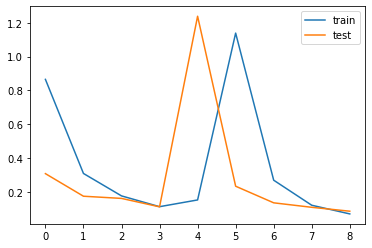

In [36]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='test')
plt.legend()
plt.show()

In [37]:
model_path = '../models/Product_Data_SQuAD_model_product.pt'
torch.save(best_model.state_dict(),model_path)

# load trained model

In [38]:
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load(model_path))
model.eval()
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

# test

In [39]:
def test_model(nlp,df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        Y_label = sample['Y_label'].values[0]  
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({'Y_label':Y_label,'predict':predict},index=[i])
        if Y_label == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
    return table

In [40]:
table = test_model(nlp,val_df)
display(table)

,Y_label,predict,是否全對
441,DOP,DOP,Yes
6020,CARBON FIBER,CARBON FIBER,Yes
2753,PROPYLENE,PROPYLENE,Yes
2960,PURIFIED ISOPHTHALIC ACID,ISOPHTHALIC ACID,No
2050,DOTP,DOTP,Yes
...,...,...,...
19332,PRECIPITATED CALCIUM CARBONATE,CALCIUM CARBONATE,No
20145,PP RESIN,PP RESIN PP1005 PP RESIN,No
7003,PP 5090T,PP,No
4296,HDPE 8001,HDPE,No


In [41]:
display(table[table['是否全對']=='Yes'])

,Y_label,predict,是否全對
441,DOP,DOP,Yes
6020,CARBON FIBER,CARBON FIBER,Yes
2753,PROPYLENE,PROPYLENE,Yes
2050,DOTP,DOTP,Yes
3258,INA,INA,Yes
...,...,...,...
19799,RESIN,RESIN,Yes
15748,POLYESTER PARTIALY ORIENTED YARN,POLYESTER PARTIALY ORIENTED YARN,Yes
1724,MALEIC ANHYDRIDE,MALEIC ANHYDRIDE,Yes
8275,INA,INA,Yes


In [42]:
display(table[table['是否全對']=='No'])

,Y_label,predict,是否全對
2960,PURIFIED ISOPHTHALIC ACID,ISOPHTHALIC ACID,No
5174,ABS RESIN,52000KGSABS RESIN,No
6845,PE,LLDPE,No
19902,EVA,BUTANEDIOL,No
7965,WOVEN GLASS EPOXY PREPREG,GLASS EPOXY PREPREG,No
...,...,...,...
19332,PRECIPITATED CALCIUM CARBONATE,CALCIUM CARBONATE,No
20145,PP RESIN,PP RESIN PP1005 PP RESIN,No
7003,PP 5090T,PP,No
4296,HDPE 8001,HDPE,No


# claculate acc and jaccard

In [43]:
def get_acc(df,t=1):
    correct = []
    correct_label = []
    for i in df.index:
        jac = get_jaccard_sim(df.loc[i,'Y_label'],df.loc[i,'predict'])
        if jac >= t:
            correct.append('yes')
        else:
            correct.append('no')
    a = pd.Series(correct)
    return a.value_counts()['yes']/len(a)

In [44]:
print('jaccard_avg_score:',np.mean([ get_jaccard_sim(table['Y_label'].loc[i],table['predict'].loc[i]) for i in table.index]))
print('acc:',get_acc(table,1))
print('放水acc:',get_acc(table,0.75))
print('放水acc:',get_acc(table,0.5))
print('放水acc:',get_acc(table,0.25))

jaccard_avg_score: 0.7188635520949203
acc: 0.5939933259176863
放水acc: 0.6028921023359288
放水acc: 0.7652947719688543
放水acc: 0.8464961067853171
